# Investigating Head On Collisions on Clear Days in the South Precinct

In [1]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

#### For region, I'm using Davidson County Police Precinct District Outlines. Let's import and check the first five rows.
- Source: https://data.nashville.gov/Police/Police-Precinct-District-Outlines-GIS-/hknv-udny

In [2]:
policedistricts = gpd.read_file('../data/policeprecinctdistricts.geojson')
print(policedistricts.crs)
policedistricts.head( )

epsg:4326


,precinct,shape_area,shape_len,geometry
0,CENTRAL,98541971.0257,46234.6717307,"MULTIPOLYGON (((-86.77525 36.14894, -86.77649 ..."
1,EAST,562260180.986,90261.1338967,"MULTIPOLYGON (((-86.74977 36.24057, -86.74955 ..."
2,HERMITAGE,2496337143.44,521944.947628,"MULTIPOLYGON (((-86.61306 36.24427, -86.61038 ..."
3,MADISON,1913402934.01,254564.86409,"MULTIPOLYGON (((-86.74955 36.24047, -86.74977 ..."
4,MIDTOWN-HILLS,1317030605.73,187104.273068,"MULTIPOLYGON (((-86.77935 36.14855, -86.77912 ..."


In [3]:
# Check that it's a geodataframe:

type(policedistricts)

geopandas.geodataframe.GeoDataFrame

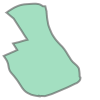

In [4]:
# Check the geometry of the first police district in the region:

policedistricts.loc[0, 'geometry']

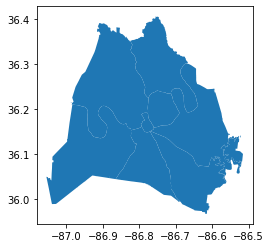

In [5]:
# Plot the geodataframe of the region:

policedistricts.plot();

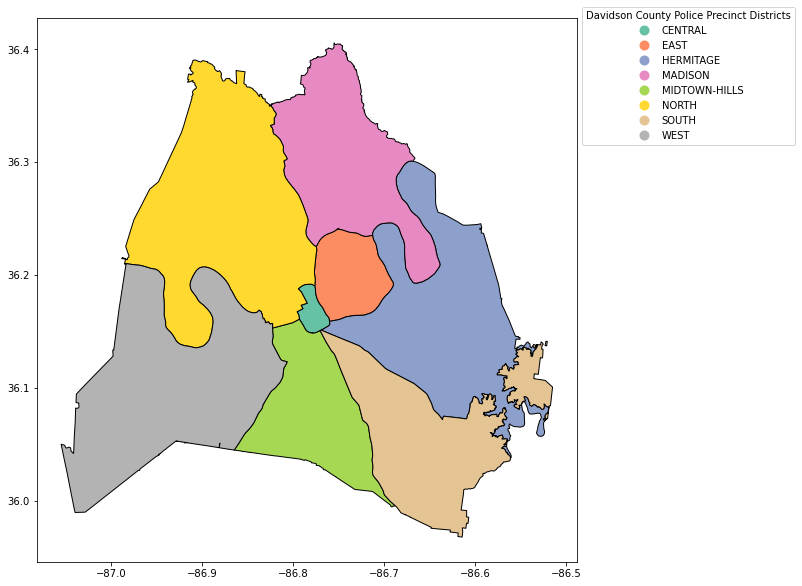

In [6]:
# Jazz up the region with colors denoting each police precinct district along with a legend:

leg_kwds = {'title': 'Davidson County Police Precinct Districts', 'loc': 'upper left', 
            'bbox_to_anchor': (1, 1.03), 'ncol': 1}

policedistricts.plot(column = 'precinct', figsize=(10, 10),
              edgecolor = 'black',
              legend = True, legend_kwds = leg_kwds, 
              cmap = 'Set2')
plt.show()

#### For points, I'm using Traffic Accidents.
- Source: https://data.nashville.gov/Police/Traffic-Accidents/6v6w-hpcw

In [7]:
# Clean data to show sideswipe accidents only:

traffic_accidents = pd.read_csv('../data/Traffic_Accidents_ClearHeadOns.csv')
print(traffic_accidents.shape)
traffic_accidents.head(3)

(3017, 12)


,Accident Number,Date and Time,Number of Motor Vehicles,Collision Type Description,Weather Description,Street Address,City,ZIP,Precinct,Latitude,Longitude,Mapped Location
0,20200614881,9/25/2020 23:29,2,HEAD-ON,CLEAR,ROSA L PARKS BLVD & CHURCH ST,NASHVILLE,37203.0,CENTRA,36.1617,-86.7839,POINT (-86.7839 36.1617)
1,20200632628,10/5/2020 10:40,2,HEAD-ON,CLEAR,DICKERSON PKE & WESTCHESTER DR,MADISON,37115.0,MADISO,36.2622,-86.7574,POINT (-86.7574 36.2622)
2,20200632611,10/5/2020 10:35,2,HEAD-ON,CLEAR,BRILEY PKWYE & BRILEY PKWYW,NASHVILLE,37207.0,MADISO,36.2396,-86.7751,POINT (-86.7751 36.2396)


In [8]:
# Create a geometry column with POINT datatype out of traffic accidents:

traffic_accidents['geometry'] = traffic_accidents.apply(lambda x: Point((x.Longitude, 
                                                         x.Latitude)), 
                                        axis=1)
traffic_accidents.head(3)

,Accident Number,Date and Time,Number of Motor Vehicles,Collision Type Description,Weather Description,Street Address,City,ZIP,Precinct,Latitude,Longitude,Mapped Location,geometry
0,20200614881,9/25/2020 23:29,2,HEAD-ON,CLEAR,ROSA L PARKS BLVD & CHURCH ST,NASHVILLE,37203.0,CENTRA,36.1617,-86.7839,POINT (-86.7839 36.1617),POINT (-86.7839 36.1617)
1,20200632628,10/5/2020 10:40,2,HEAD-ON,CLEAR,DICKERSON PKE & WESTCHESTER DR,MADISON,37115.0,MADISO,36.2622,-86.7574,POINT (-86.7574 36.2622),POINT (-86.7574 36.2622)
2,20200632611,10/5/2020 10:35,2,HEAD-ON,CLEAR,BRILEY PKWYE & BRILEY PKWYW,NASHVILLE,37207.0,MADISO,36.2396,-86.7751,POINT (-86.7751 36.2396),POINT (-86.77509999999999 36.2396)


In [9]:
# I want the crs of traffic accidents to match that of police districts, namely EPSG:4326
policedistricts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
ta_geo = gpd.GeoDataFrame(traffic_accidents, 
                           crs = policedistricts.crs, 
                           geometry = traffic_accidents['geometry'])

In [11]:
type(ta_geo) # Hooray, it is now a geodataframe!

geopandas.geodataframe.GeoDataFrame

#### Spatial join the two geodataframes together
- For policedistricts, keep columns 'precinct' and 'geometry'

In [12]:
policedistricts = policedistricts[['precinct', 'geometry']]

In [13]:
ta_by_pd = gpd.sjoin(ta_geo, policedistricts, op = 'within')
ta_by_pd.head()

,Accident Number,Date and Time,Number of Motor Vehicles,Collision Type Description,Weather Description,Street Address,City,ZIP,Precinct,Latitude,Longitude,Mapped Location,geometry,index_right,precinct
0,20200614881,9/25/2020 23:29,2,HEAD-ON,CLEAR,ROSA L PARKS BLVD & CHURCH ST,NASHVILLE,37203.0,CENTRA,36.1617,-86.7839,POINT (-86.7839 36.1617),POINT (-86.78390 36.16170),0,CENTRAL
124,20210535843,10/14/2021 9:04,2,HEAD-ON,CLEAR,LAFAYETTE ST & 4TH AVS,NASHVILLE,37210.0,CENTRA,36.1518,-86.7713,POINT (-86.7713 36.1518),POINT (-86.77130 36.15180),0,CENTRAL
125,20150113733,2/3/2015 0:15,2,HEAD-ON,CLEAR,EXIT 49 & I 24,NASHVILLE,37213.0,CENTRA,36.1661,-86.7657,POINT (-86.7657 36.1661),POINT (-86.76570 36.16610),0,CENTRAL
141,20150038003,1/12/2015 5:50,2,HEAD-ON,CLEAR,INTERSTATE DR & SHELBY AVE,NASHVILLE,37213.0,CENTRA,36.1662,-86.7658,POINT (-86.7658 36.1662),POINT (-86.76580 36.16620),0,CENTRAL
145,20150151543,2/13/2015 8:14,2,HEAD-ON,CLEAR,11TH AVE N & CHARLOTTE AVE,NASHVILLE,37203.0,CENTRA,36.1621,-86.7906,POINT (-86.7906 36.1621),POINT (-86.79060 36.16210),0,CENTRAL


In [14]:
# Count how many traffic accidents are within each police precinct district:

ta_by_pd['precinct'].value_counts()

SOUTH            678
HERMITAGE        504
MIDTOWN-HILLS    431
MADISON          317
NORTH            307
EAST             291
WEST             268
CENTRAL          182
Name: precinct, dtype: int64

#### Let's take a look at the South precinct since it has the most traffic accidents.
- Filter ta_by_pd to just get traffic accidents for the south district
- Filter traffic accidents df to just get the polygon (row) for the south district

In [15]:
ta_in_south = ta_by_pd.loc[ta_by_pd['precinct'] == 'SOUTH']
ta_in_south.shape

(678, 15)

In [16]:
polygonsouth = policedistricts.loc[policedistricts['precinct'] == 'SOUTH']
polygonsouth.shape

(1, 2)

#### Plot these two together to map the South precinct.

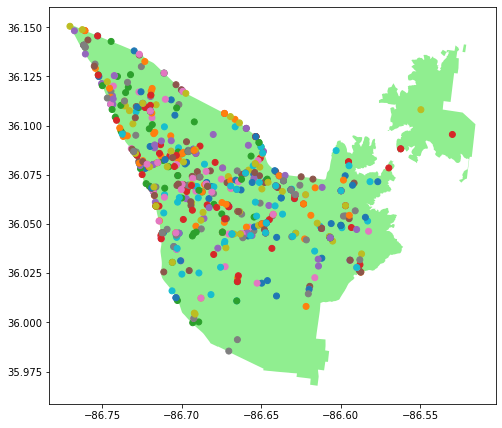

In [17]:
ax = polygonsouth.plot(figsize = (8, 10), color = 'lightgreen') # Make polygon lightgreen
ta_in_south.plot( ax = ax, column = 'Collision Type Description'); # Partition ta by Collision Type Description
plt.show();

#### Add a street map with the folium package!
- Make use of a GeoSeries attribute (.centroid) which gives the center of a polygon
- Since there are two polygons which should we use?

In [18]:
# Find the center point of polygonsouth:

polygonsouth.geometry.centroid

C:\Users\Jasmine\AppData\Local\Temp\ipykernel_8472\3053778652.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygonsouth.geometry.centroid


6    POINT (-86.64764 36.05903)
dtype: geometry

#### I thought there were two polygons but it only returned one center point so it's just one polygon then...?

In [19]:
# Pull the full center coordinates from that index (6):

center = polygonsouth.geometry.centroid[6]
print(center)

POINT (-86.64764171909046 36.0590275416039)


C:\Users\Jasmine\AppData\Local\Temp\ipykernel_8472\3630707512.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = polygonsouth.geometry.centroid[6]


#### Since the result POINT has longitude first, we have to swap the values for folium (because it likes latitude first).

In [20]:
# Reverse the order when constructing the array for folium location:
area_center = [center.y, center.x]

# Check the order of area_center, the location for our folium map:
print(area_center)

[36.0590275416039, -86.64764171909046]


In [21]:
# Create the map of the South precinct and show it:

map_south = folium.Map(location = area_center, zoom_start = 12)
map_south

#### itterows() is a generator that iterates through the rows of a DataFrame and returns a tuple with the row id and row values.
- Below, we are printing the row values for the first 3 row as we iterate through the GeoDataFrame of bus stops in 37207.
- This idea will be helpful for creating our markers!

In [22]:
i = 0
for row_index, row_values in ta_in_south.iterrows():
    if i <3: 
        print('index is', row_index)
        print('values are:')
        print(' ')
        print(row_values)
        print('------------------------- ')
        i+=1

index is 4
values are:
 
Accident Number                              20200641744
Date and Time                            10/9/2020 22:31
Number of Motor Vehicles                               2
Collision Type Description                       HEAD-ON
Weather Description                                CLEAR
Street Address                MURFREESBORO PKE & BELL RD
City                                             ANTIOCH
ZIP                                              37013.0
Precinct                                           SOUTH
Latitude                                          36.072
Longitude                                        -86.636
Mapped Location                   POINT (-86.636 36.072)
geometry                          POINT (-86.636 36.072)
index_right                                            6
precinct                                           SOUTH
Name: 4, dtype: object
------------------------- 
index is 5
values are:
 
Accident Number                              

#### Create map_south again with additional features:
- Add the South precinct outline (polygonsouth)
- Iterate through the ta_in_south to
    - Create location from each lat and long
    - Create a popup from the Collision Type Description column
    - Create a custom icon from font-awesome
    - Build a marker from each location and popup and (optionally) your custom icon
    - Add the marker to map_south
- Display map_south

In [23]:
# # Folium map the South precinct boundary:
map_south = folium.Map(location =  area_center, zoom_start = 12)

folium.GeoJson(polygonsouth).add_to(map_south)

# # Iterate through ta_in_south to create locations and markers 
# # for each traffic accident
# # Remember for Folium locations, lat is listed first!!

for row_index, row_values in ta_in_south.iterrows():
    loc = [row_values['Latitude'], row_values['Longitude']]
    pop = str(row_values['Date and Time'])
    icon=folium.Icon(color="red",icon="car", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop, icon = icon) 

    marker.add_to(map_south)
map_south.save('../maps/map_south.html')

# # Display the map!
map_south

#### The above map shows all the locations (with date and time in popup) where a head on collision occurred on a clear day within the South precinct of Davidson County (which has the highest reported head on collisions).
- It is difficult to find a pattern by looking at this so let's try making a marker cluster map to see where most head ons on a clear day occurred

In [24]:
cluster_map_south = folium.Map(location =  area_center, zoom_start = 12)

#create a marker cluster
marker_cluster = MarkerCluster().add_to(cluster_map_south)

folium.GeoJson(polygonsouth).add_to(cluster_map_south)

# inside the loop add each marker to the cluster
for row_index, row_values in ta_in_south.iterrows():
    loc = [row_values['Latitude'], row_values['Longitude']]
    pop = str(row_values['Date and Time'])
    icon=folium.Icon(color="red",icon="car", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop,
    icon = icon) 
    
    marker.add_to(marker_cluster)

    
#save an interactive HTML map by calling .save()
cluster_map_south.save('../maps/clustersouth.html')

cluster_map_south

#### Now it is a bit easier to see approximately where most head on collisions on a clear day occurred -- namely around Bell Road east of I-24.
- Area of interest: The stretch of Hamilton Church Road just west of Murfreesboro Pike has 11 reported head on collisions! Looking at the layout of the road, this high occurrence may be due to drivers turning into the wrong lane from the side roads as the road is split into one-way directions. Perhaps whoever designs the roads around here can use this data to improve driver safety.